In [8]:
#parsing
import os
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta
import hashlib
import json
import random

# Data manipulation
import pandas as pd
import numpy as np


#Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
import optuna

#Heatmap and VIF
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [9]:
#Catboost model
# --- Load data ---
df = pd.read_excel("../data/all_listings_gold.xlsx")

# --- Identify columns ---
numeric_cols = ['Mileage_sq', 'log_mileage','listing_score']
categorical_cols = [
    'Series','model_category','state_yes', 'Transmission','state_Rear drive', 'matching_yes', 'Car location',
    'is_fully_restored', 'Paint-to-Sample (PTS)'
]
target = 'price_in_eur'

# Log-transform the price (still predicting log-price for stability)
df = df.dropna(subset=[target])  # Remove rows with missing target
df[target] = np.log(df[target])

X = df[categorical_cols + numeric_cols]
y = df[target]

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Prepare CatBoost Pool with categorical features ---
cat_features = [X.columns.get_loc(col) for col in categorical_cols]  # CatBoost uses index

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

common_params = {
    'iterations': 652, 
    'learning_rate': 0.0964, 
    'depth': 5, 
    'l2_leaf_reg': 9.3, 
    'bootstrap_type': 'Bayesian',
    'task_type': 'GPU',
    'verbose': 100,
    'random_seed': 42
    }

model_lower = CatBoostRegressor(
    loss_function='Quantile:alpha=0.05',
    **common_params
)

model_upper = CatBoostRegressor(
    loss_function='Quantile:alpha=0.95',
    **common_params
)

# Train models
model_lower.fit(train_pool)
model_upper.fit(train_pool)

# --- Predict intervals ---
pred_lower = model_lower.predict(test_pool)
pred_upper = model_upper.predict(test_pool)

# --- Optional: Train a standard model for point prediction (median) ---
model_median = CatBoostRegressor(
    loss_function='Quantile:alpha=0.5',
    **common_params
)

# Train median model
model_median.fit(train_pool)
pred_median = model_median.predict(test_pool)

# --- Evaluate model ---
def evaluate_predictions(y_true, y_pred, label=""):
    print(f"{label} R²: {r2_score(y_true, y_pred):.4f}")
    print(f"{label} MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"{label} RMSE: {root_mean_squared_error(y_true, y_pred):.4f}")

evaluate_predictions(y_test, pred_median, label="Median prediction")

# --- Example output for the first few cars ---
for i in range(10):
    print(f"\nCar {i+1}")
    print(f"Predicted log-price: {pred_median[i]:.2f}")
    print(f"90% CI: ({pred_lower[i]:.2f}, {pred_upper[i]:.2f})")
    print(f"True log-price: {y_test.iloc[i]:.2f}")


0:	learn: 0.0509726	total: 26.5ms	remaining: 17.3s
100:	learn: 0.0325846	total: 2.53s	remaining: 13.8s
200:	learn: 0.0242414	total: 5.03s	remaining: 11.3s
300:	learn: 0.0201414	total: 7.88s	remaining: 9.19s
400:	learn: 0.0183239	total: 10.3s	remaining: 6.45s
500:	learn: 0.0172345	total: 13s	remaining: 3.92s
600:	learn: 0.0164836	total: 15.6s	remaining: 1.32s
651:	learn: 0.0161866	total: 16.8s	remaining: 0us
0:	learn: 0.0580667	total: 19.5ms	remaining: 12.7s
100:	learn: 0.0384801	total: 2.27s	remaining: 12.4s
200:	learn: 0.0288698	total: 4.7s	remaining: 10.5s
300:	learn: 0.0239482	total: 7.16s	remaining: 8.35s
400:	learn: 0.0215279	total: 9.62s	remaining: 6.02s
500:	learn: 0.0201784	total: 12.2s	remaining: 3.67s
600:	learn: 0.0194034	total: 14.7s	remaining: 1.24s
651:	learn: 0.0190486	total: 16s	remaining: 0us
0:	learn: 0.2147375	total: 23.2ms	remaining: 15.1s
100:	learn: 0.0772626	total: 2.44s	remaining: 13.3s
200:	learn: 0.0717201	total: 4.94s	remaining: 11.1s
300:	learn: 0.0682836	to

In [50]:
# Load and preprocess data
df = pd.read_excel("../data/all_listings_gold.xlsx")

df = df.dropna(subset=[target])
df[target] = np.log(df[target])  # log-price
X = df[categorical_cols + numeric_cols]
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get categorical column indices
cat_features = [X.columns.get_loc(col) for col in categorical_cols]

# --- Optuna objective function ---
def objective(trial):
    params = {
    "iterations": trial.suggest_int("iterations", 280, 600),
    "learning_rate": trial.suggest_float("learning_rate", 0.15, 0.35, log=True),  # restrict max LR
    "depth": 4,
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 4, 10, log=True),
    "bootstrap_type": "Bayesian",
    "bagging_temperature": trial.suggest_float("bagging_temperature", 0.05, 0.3),
    "grow_policy": "SymmetricTree",
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 25, 60),
    "task_type": "GPU",
    "verbose": 0,
    "random_seed": 42,
    "loss_function": "RMSE"
    }

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_test, y_test, cat_features=cat_features)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

    preds = model.predict(valid_pool)
    rmse = root_mean_squared_error(y_test, preds)
    return rmse

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=75, timeout=1200)  # Limit to 20 minutes or 50 trials

# Show best result
print("Best RMSE:", study.best_value)
print("Best Params:", study.best_params)

# Train final model with best params
best_model = CatBoostRegressor(
    **study.best_params,
    task_type="GPU",
    verbose=100,
    random_seed=42,
    loss_function="RMSE"
)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
best_model.fit(train_pool)


KeyboardInterrupt: 

In [43]:

importance = optuna.importance.get_param_importances(study)
print("Hyperparameter Importances:")
for param, imp in importance.items():
    print(f"{param}: {imp:.4f}")


Hyperparameter Importances:
l2_leaf_reg: 0.2902
bagging_temperature: 0.2899
learning_rate: 0.1631
iterations: 0.1415
min_data_in_leaf: 0.1154


In [44]:
optuna.visualization.plot_param_importances(study)

In [3]:
from optuna.visualization import plot_parallel_coordinate

fig = plot_parallel_coordinate(study)
fig.show()


NameError: name 'study' is not defined

In [46]:
from optuna.visualization import plot_slice

fig = plot_slice(study)
fig.show()


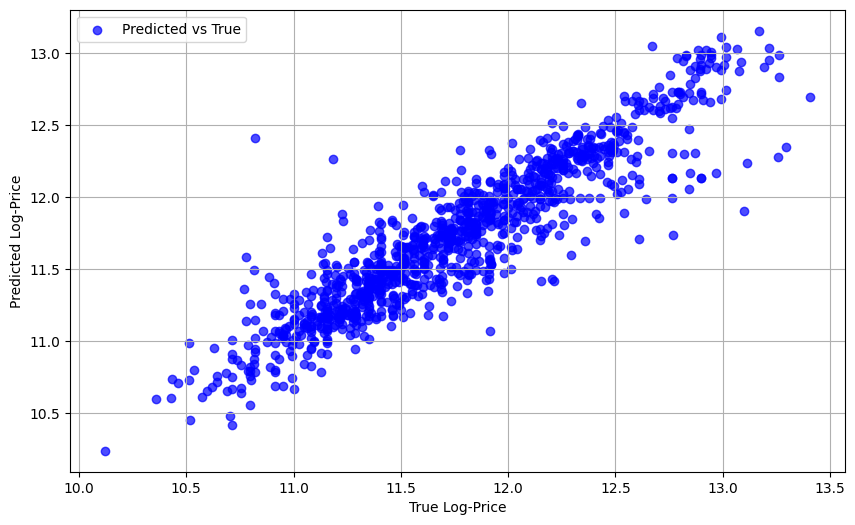

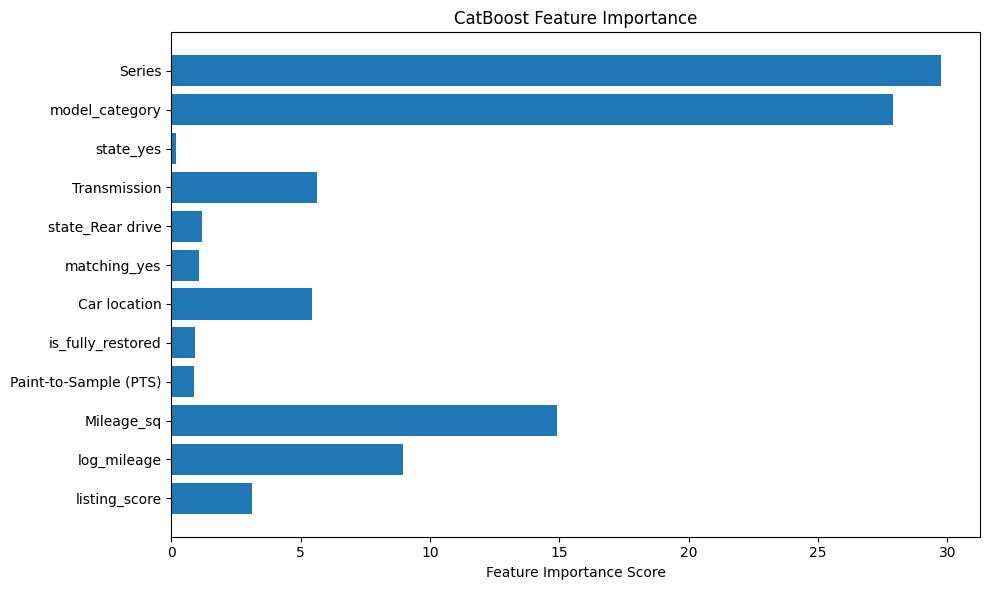

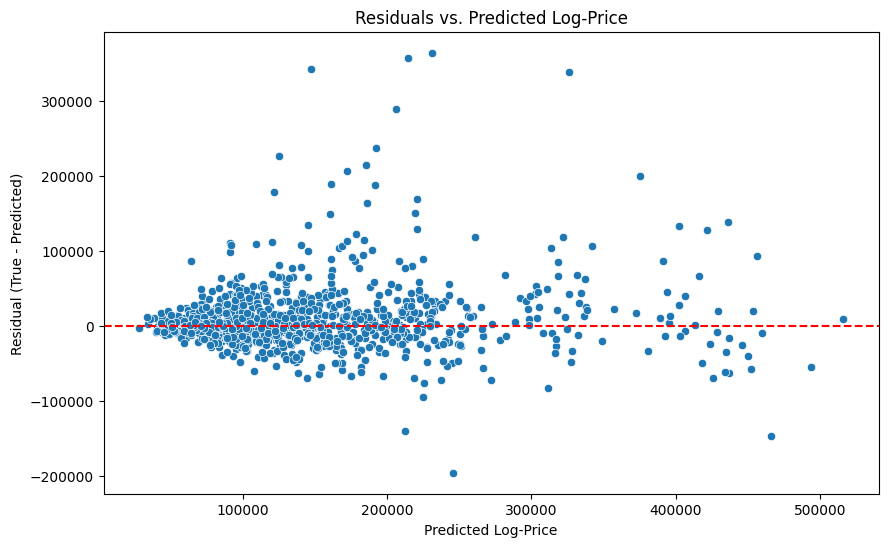

Fraction of predictions within 90% CI: 83.55%


OSError: Cannot save file into a non-existent directory: 'results'

In [ ]:

# --- Updated plot for 90% CI ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred_median, color='blue', label='Predicted vs True', alpha=0.7)
plt.xlabel('True Log-Price')
plt.ylabel('Predicted Log-Price')
plt.legend()
plt.grid(True)
plt.show()


# Assuming you have a fitted model and your train dataset
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)

# Get feature importance
importances = model_median.get_feature_importance(train_pool)
feature_names = X_train.columns

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance Score")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# --- Load original dataset and preprocess ---
df = pd.read_excel("../data/all_listings_gold.xlsx").dropna(subset=["price_in_eur"])
df["log_price"] = np.log(df["price_in_eur"])

# Preserve original indices in train-test split
X = df[categorical_cols + numeric_cols]
y = df["log_price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# After prediction, create results DataFrame with correct index
results_df = X_test.copy()
results_df["true_log_price"] = y_test
results_df["pred_log_price"] = pred_median
results_df["pred_lower_log"] = pred_lower
results_df["pred_upper_log"] = pred_upper

# Add actual and predicted prices (non-log)
results_df["true_price"] = np.exp(results_df["true_log_price"])
results_df["pred_price"] = np.exp(results_df["pred_log_price"])
results_df["pred_lower_price"] = np.exp(results_df["pred_lower_log"])
results_df["pred_upper_price"] = np.exp(results_df["pred_upper_log"])

# --- Filter for underpriced listings ---
underpriced_df = results_df[
    (results_df["true_log_price"] < results_df["pred_log_price"]) &
    (results_df["true_log_price"] < results_df["pred_lower_log"])
]

# --- Merge back with original listings using the correct index ---
full_details = df.loc[underpriced_df.index]  # Select matching rows by index
final_df = pd.concat([full_details, underpriced_df.drop(columns=X_test.columns)], axis=1)
final_df = final_df.drop(columns=["log_price", "pred_log_price", "pred_lower_log", "pred_upper_log"])
final_df = final_df[final_df["price_in_eur"] < 90000]

# --- Outlier Detection ---
# Calculate residuals (differences between true and predicted prices)
results_df["residual"] = results_df["true_price"] - results_df["pred_price"]

# Calculate the standard deviation of residuals
residual_std = np.std(results_df["residual"])

# Define the threshold for outliers (e.g., 3 standard deviations)
outlier_threshold = 1.5 * residual_std

plt.figure(figsize=(10, 6))
sns.scatterplot(x=results_df["pred_price"], y=results_df["residual"])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Log-Price")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals vs. Predicted Log-Price")
plt.show()

within_interval = ((y_test >= pred_lower) & (y_test <= pred_upper)).mean()
print(f"Fraction of predictions within 90% CI: {within_interval:.2%}")


# Identify outliers (absolute residuals greater than the threshold)
outliers_df = results_df[abs(results_df["residual"]) > outlier_threshold]

# --- Merge outliers with full details ---
full_outlier_details = df.loc[outliers_df.index]
outlier_final_df = pd.concat([full_outlier_details, outliers_df.drop(columns=X_test.columns)], axis=1)
outlier_final_df = outlier_final_df.drop(columns=["log_price", "pred_log_price", "pred_lower_log", "pred_upper_log"])

# --- Export to Excel ---
final_df.to_excel("../results/underpriced_listings.xlsx", index=False)
outlier_final_df.to_excel(f"../results/outliers_{datetime.today().date()}.xlsx", index=False)

print("✅ Exported accurately matched underpriced listings to underpriced_listings.xlsx")
print(f"✅ Exported outliers to outliers_{datetime.today().date()}.xlsx")

In [7]:
import os
from datetime import datetime

print("Notebook CWD:", os.getcwd())
print("Repo root listing (one level):", os.listdir(os.getcwd())[:40])

results_path = os.path.abspath("../results")
print("Resolved results path:", results_path)
print("Exists:", os.path.exists(results_path), "isdir:", os.path.isdir(results_path))
print("Writable (os.access):", os.access(results_path, os.W_OK))

# Quick write test
try:
    os.makedirs(results_path, exist_ok=True)
    test_file = os.path.join(results_path, ".write_test")
    with open(test_file, "w") as f:
        f.write("ok")
    os.remove(test_file)
    print("Write test OK")
except Exception as e:
    print("Write test failed:", repr(e))

# Attempt safe export and show full exception if it fails
try:
    final_df.to_excel(os.path.join(results_path, "underpriced_listings.xlsx"), index=False)
    outlier_final_df.to_excel(os.path.join(results_path, f"outliers_{datetime.today().date()}.xlsx"), index=False)
    print("✅ Export succeeded to", results_path)
except Exception as e:
    print("Export failed (full exception):", repr(e))
    raise

Notebook CWD: \\nas_jaxon\Software\Python\Porsche\notebooks
Repo root listing (one level): ['#VIF.ipynb', 'Catboost model.ipynb', 'catboost_info', 'debug_output.html', 'ElasticNet.ipynb', 'Listings_bronzetosilver.ipynb', 'outliers_full_df.xlsx', 'Predictive_regression.ipynb', 'results', 'Ridge.ipynb', 'scrape_911.ipynb']
Resolved results path: \\nas_jaxon\Software\Python\Porsche\results
Exists: True isdir: True
Writable (os.access): True
Write test OK
✅ Export succeeded to \\nas_jaxon\Software\Python\Porsche\results
